In [55]:
import zipfile
from collections import Counter
import matplotlib.pyplot as plt
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
warnings.filterwarnings("ignore")

zip_path = 'D:/flame/scripts/data/HumanML3D/texts.zip'

In [19]:
# 단어의 빈도수를 저장할 Counter 객체 생성
word_counter = Counter()

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file_name in zip_ref.namelist():
        # .txt 파일만 처리
        if not file_name.endswith('.txt'):
            continue
        with zip_ref.open(file_name) as f:
            try:
                text = f.read().decode('utf-8')
            except UnicodeDecodeError:
                text = f.read().decode('latin-1')
        # 파일 내 라인별 처리
        for line in text.splitlines():
            parts = line.strip().split('#')
            if len(parts) < 2:
                continue
            tokens_info = parts[1].split()
            for token in tokens_info:
                if '/' not in token:
                    continue
                word, pos = token.rsplit('/', 1)
                # VERB 태그인 경우에만 카운트
                if pos == 'VERB':
                    word_counter[word] += 1

상위 20개 단어:
person: 65606
left: 20208
right: 20208
walks: 19462
forward: 17882
man: 11606
arms: 11300
hand: 10308
back: 10082
hands: 9160
something: 8226
steps: 7562
walking: 7414
arm: 6432
side: 5868
around: 5592
turns: 5518
standing: 4712
takes: 3922
stands: 3918


In [28]:
# 가장 많이 등장한 상위 20개 단어 출력
print("상위 20개 단어:")
for word, count in word_counter.most_common(100):
    print(f"{word}: {count}")

상위 20개 단어:
person: 65606
left: 20208
right: 20208
walks: 19462
forward: 17882
man: 11606
arms: 11300
hand: 10308
back: 10082
hands: 9160
something: 8226
steps: 7562
walking: 7414
arm: 6432
side: 5868
around: 5592
turns: 5518
standing: 4712
takes: 3922
stands: 3918
raises: 3586
moves: 3430
slowly: 3370
front: 3194
leg: 3178
figure: 2960
head: 2866
foot: 2728
moving: 2722
backwards: 2460
jumps: 2440
one: 2346
step: 2344
puts: 2324
motion: 2176
lifts: 2134
slightly: 2126
straight: 2124
circle: 2124
someone: 2098
object: 2072
bends: 2032
holding: 1804
picks: 1780
sits: 1768
runs: 1766
body: 1680
like: 1670
jumping: 1650
ground: 1516
position: 1480
place: 1458
towards: 1458
still: 1440
waves: 1428
throws: 1422
two: 1420
holds: 1418
legs: 1410
clockwise: 1394
walk: 1380
lowers: 1356
sides: 1282
knees: 1268
makes: 1264
appears: 1256
kicks: 1250
face: 1242
starts: 1208
gets: 1200
counterclockwise: 1197
jogs: 1178
looks: 1162
sitting: 1160
using: 1160
quickly: 1150
stops: 1140
brings: 1094
forw

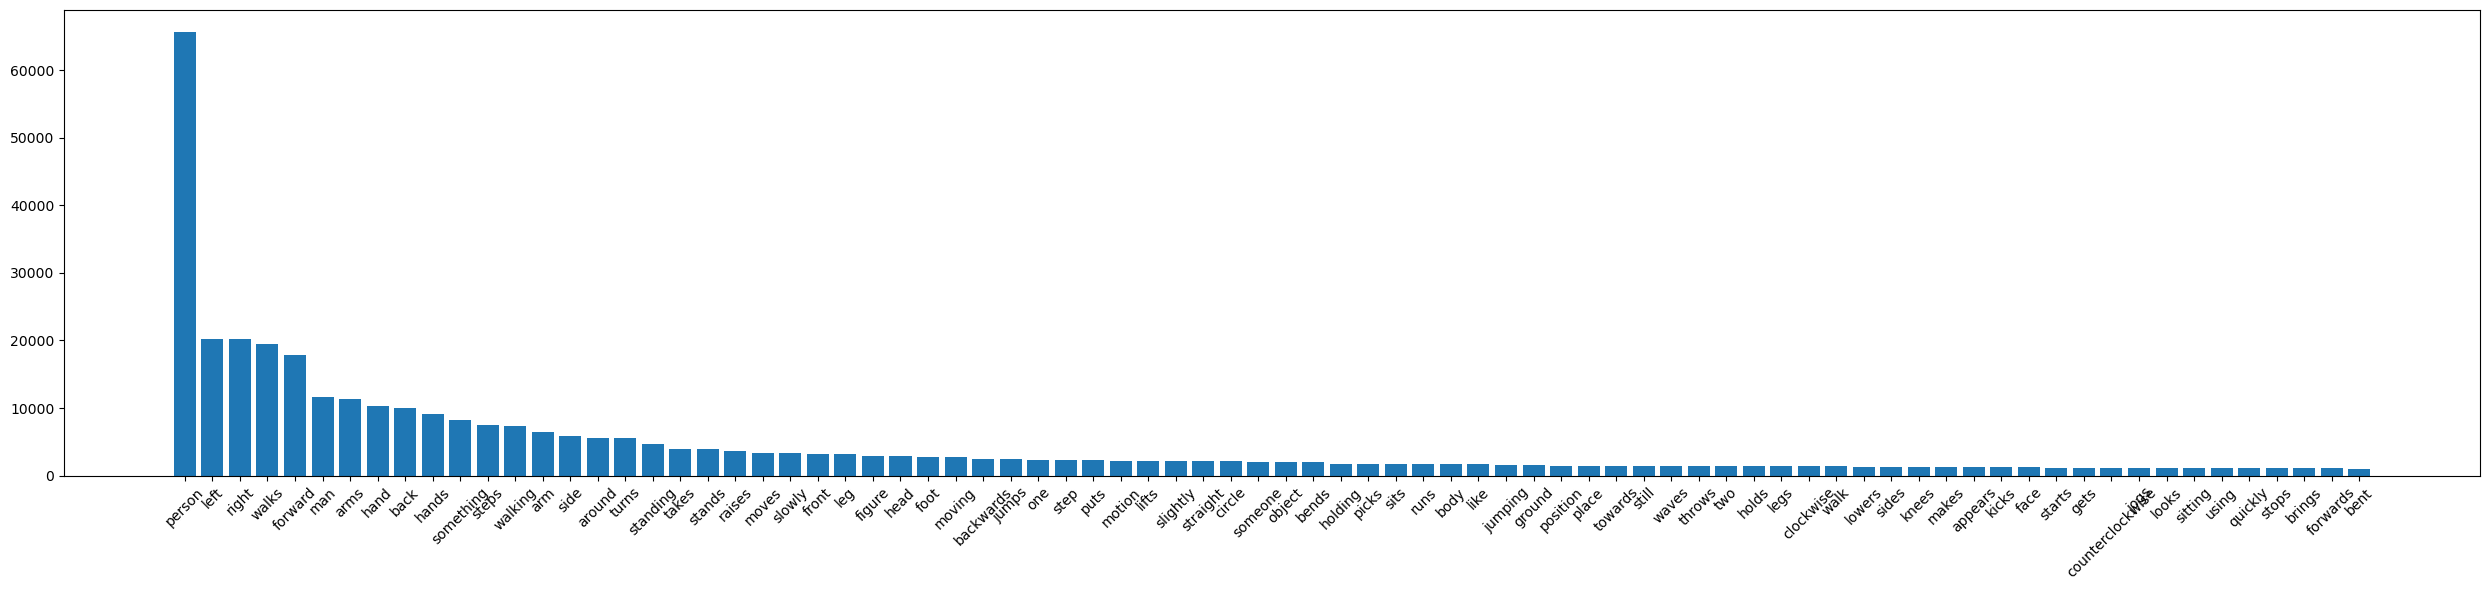

In [41]:
# 상위 20개의 단어 분포를 막대 그래프로 시각화
top_words, top_counts = zip(*word_counter.most_common(80))
plt.figure(figsize=(25, 6))
plt.bar(top_words, top_counts)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [52]:
# 원형 + 원형ing + 원형s
target_word = 'slide'
target_count = word_counter[target_word]
print(f"'{target_word}'의 개수: {target_count}")

'slide'의 개수: 28


In [49]:
target_word = 'slides'
target_count = word_counter[target_word]
print(f"'{target_word}'의 개수: {target_count}")

'slides'의 개수: 146


In [50]:
target_word = 'sliding'
target_count = word_counter[target_word]
print(f"'{target_word}'의 개수: {target_count}")

'sliding'의 개수: 76
